# Transfer Learning on a network, where roads are clustered into classes

In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipdb
import os

In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import backend as K
import tensorflow.keras as keras
from tensorflow.keras.layers import Layer
import dan_models
import dan_utils
from sklearn.manifold import TSNE

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.compat.v1.enable_eager_execution()
tf.executing_eagerly()

True

# Load data

In [4]:
class_set = [2, 3, 4]
randseed = 25
res = 11
v, v_class, id_402, part1, part2, seg, det_list_class, near_road_set  \
        = dan_utils.load_data(class_set, res, randseed)

There are 5 class(es)


C:\Users\10169\anaconda3\envs\dan_traff\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [5]:
v_class[0].shape

(40, 4467)

### Visulization

In [6]:
def plot_dets(det_list_class_i, if_save):
    
    for i in range(len(id_402)):
        det_id = id_402.loc[i, 'id']
        cls_402 = id_402.loc[i, 'class_i']
        try:
            cls_det = part1[part1['det'] == det_id]['0'].values[0]
            if cls_402 != cls_det:
                part1.loc[part1['det'] == det_id, '0'] = cls_402
                print(i)
        except:
            cls_det = part2[part2['det'] == det_id]['0'].values[0]
            if cls_402 != cls_det:
                part2.loc[part2['det'] == det_id, '0'] = cls_402
                print(i)
    
    
    fig = plt.figure(figsize=[40, 15], dpi=75)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    for i in range(len(det_list_class_i)):
        det_id = det_list_class_i[i]
        x = id_402.loc[id_402['id']==det_id, 'lat']
        y = id_402.loc[id_402['id']==det_id, 'long']
#         ipdb.set_trace()
        if det_id in part1['det'].values:
            ax1.plot(x, y, marker='+', color='red', markersize=10, markerfacecolor='none')
            ax1.text(x-0.005, y, det_id, rotation=45)
        elif det_id in part2['det'].values:
            ax2.plot(x, y, marker='o', color='red', markersize=10, markerfacecolor='none')
            ax2.text(x-0.005, y, det_id, rotation=45)
            
    plt.show()
    if if_save:
        fig.savefig('../network_classification/img/%i_res%i_class_%i.png'%(randseed, res, class_i_))
        print(1)
    plt.close()
    
    return

10
137
138
139
140
142
170
212
341
342
343
344
345
346


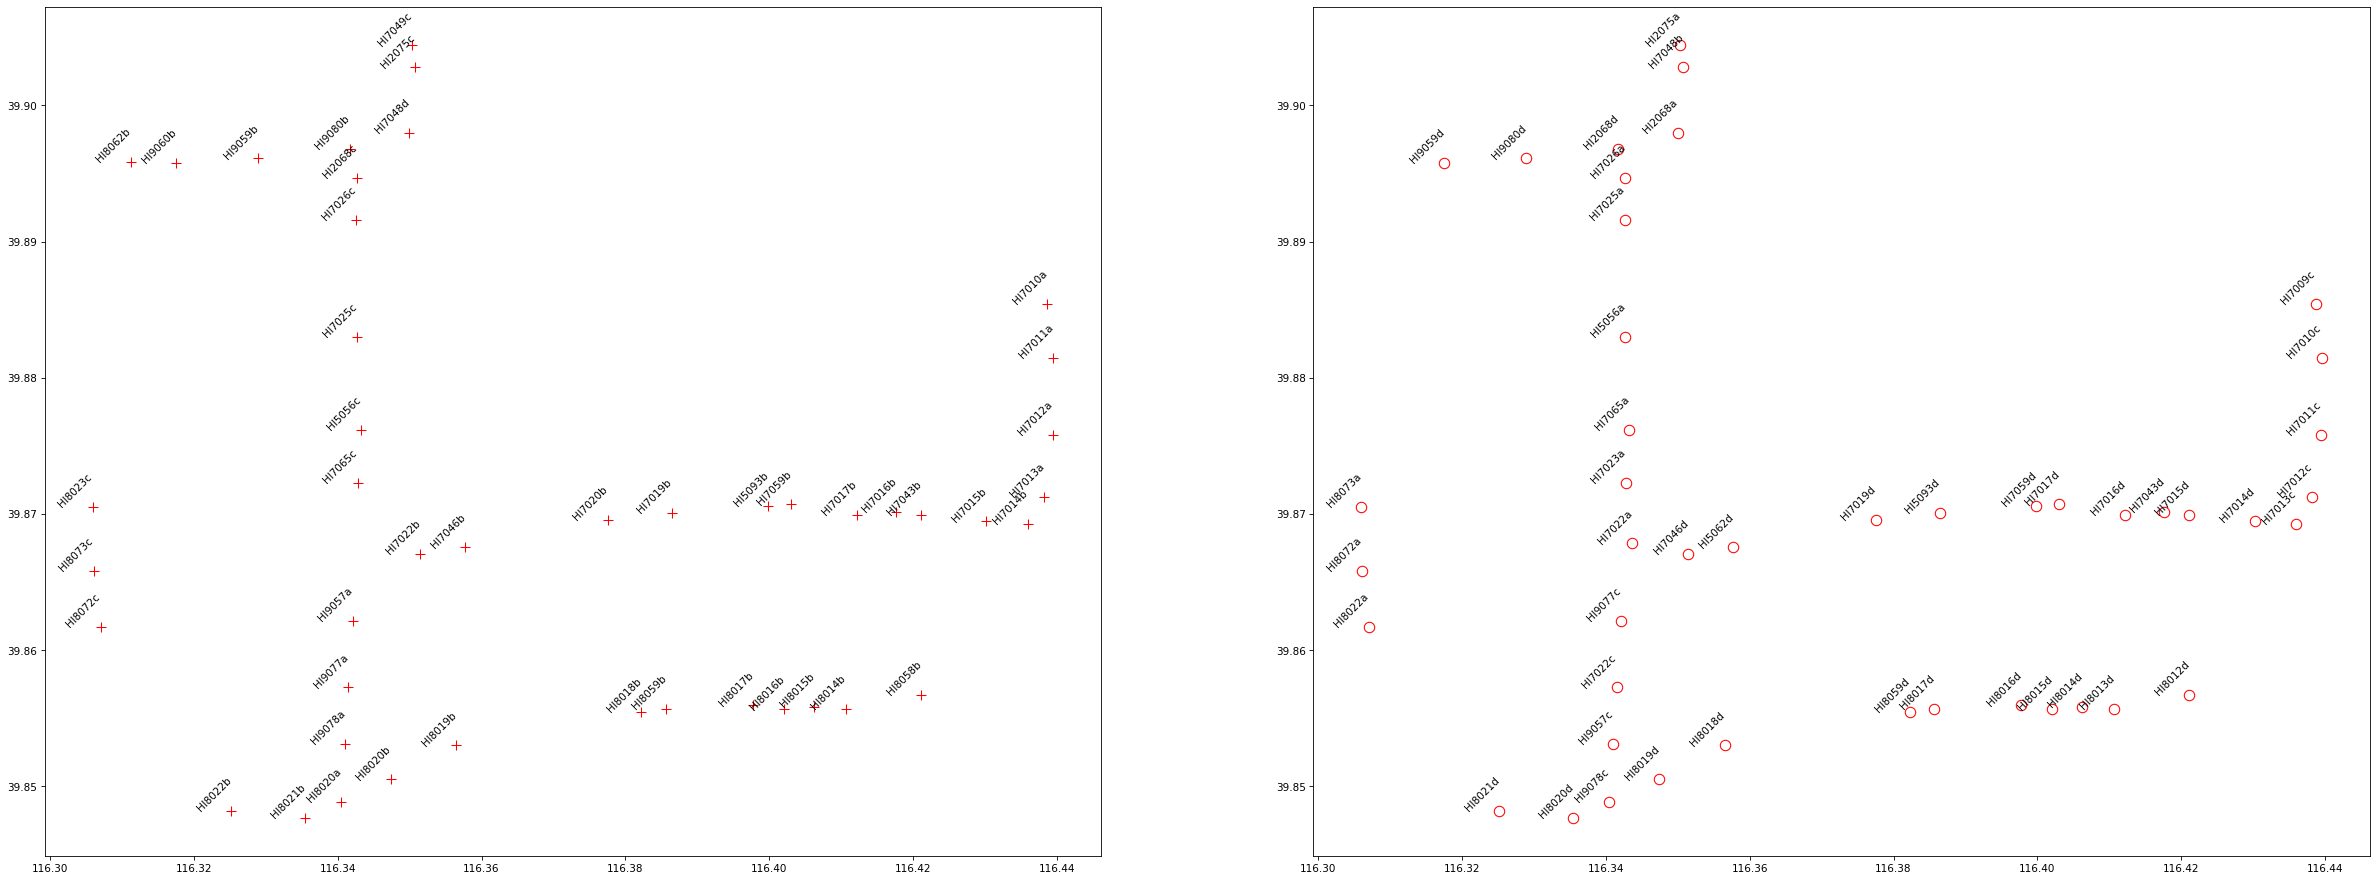

In [7]:
# ind, class
# 0  , blue
# 1  , green
# 2  , yellow  <--
# 3  , black   <--
# 4  , red     <--
class_color_set = ['b', 'g', 'y', 'black', 'r']
class_i_ = 2
plot_dets(det_list_class[class_i_], if_save=0)

## Evaluation of 2 datasets

In [8]:
def get_NSk(set1, set2):
    # designated for v_class1 and 2
    set1_v_mean = set1.iloc[:, 2:-1].T.mean().T
    set2_v_mean = set2.iloc[:, 2:-1].T.mean().T
    
    var1 = set1_v_mean.std()**2
    var2 = set2_v_mean.std()**2
    
    u1 = set1_v_mean.mean()
    u2 = set2_v_mean.mean()
    
    return 2*var1 / (var1 + var2 + (u1 - u2)**2)

In [9]:
NSk_set = np.array([])

for i in class_set:
    for j in class_set:
        if i!=j:
            NSk = get_NSk(v_class[i], v_class[j])
            NSk_set = np.append(NSk_set, NSk)

print(NSk_set.mean())

0.9717564840290976


# 源代码如下 （训练）
# Input classes here

In [10]:
# ind, class
# 0  , blue
# 1  , green
# 2  , yellow  <--
# 3  , black   <--
# 4  , red     <--
class_src = 2
v_class1 = v_class[class_src]  # source
near_road1 = np.array(near_road_set[class_src])

class_tar = 4
v_class2 = v_class[class_tar]  # target
near_road2 = np.array(near_road_set[class_tar])

num_links = v_class1.shape[0]

In [11]:
near_road_src = near_road1
flow_src = v_class1.iloc[:, 2:-1]
prop = 1  # proportion of training data
from_day = 1
to_day = 24

image_train_source, image_test_source, day_train_source, day_test_source, label_train_source, label_test_source\
= dan_utils.sliding_window(
    flow_src, near_road_src, from_day, to_day, prop, num_links
)

(2772, 5, 12, 40)
(2772, 5, 12, 40)
(0, 5, 12, 40)
(2772, 40, 6)
(0, 40, 6)


In [12]:
near_road_tar = near_road2
flow_tar = v_class2.iloc[:, 2:-1]
prop = 3/10
from_day = 22
to_day = 31

image_train_target, image_test_target, day_train_target, day_test_target, label_train_target, label_test_target\
= dan_utils.sliding_window(
    flow_tar, near_road_tar, from_day, to_day, prop, num_links
)

dup_mul = image_train_source.shape[0]//image_train_target.shape[0]
dup_r   = image_train_source.shape[0]%image_train_target.shape[0]

image_train_target, day_train_target, label_train_target = \
np.concatenate((np.tile(image_train_target, [dup_mul, 1, 1, 1]), image_train_target[:dup_r, :, :, :]), axis=0),\
np.concatenate((np.tile(day_train_target, [dup_mul, 1, 1]), day_train_target[:dup_r, :, :]), axis=0),\
np.concatenate((np.tile(label_train_target, [dup_mul, 1, 1]), label_train_target[:dup_r, :, :]), axis=0),



(1008, 5, 12, 40)
(302, 5, 12, 40)
(706, 5, 12, 40)
(302, 40, 6)
(706, 40, 6)


In [13]:
print(image_train_target.shape)
print(image_test_target.shape)
print(day_train_target.shape)
print(day_test_target.shape)
print(label_train_target.shape)
print(label_test_target.shape)

(2772, 5, 12, 40)
(706, 5, 12, 40)
(2772, 40, 6)
(706, 40, 6)
(2772, 40, 6)
(706, 40, 6)


In [14]:
t_input = image_train_source.shape[2]
t_pre = label_train_source.shape[2]
k = image_train_source.shape[1]

#模型构建
input_data = keras.Input(shape=(k,t_input,num_links), name='input_data')
input_HA = keras.Input(shape=(num_links, t_pre), name='input_HA')

finish_model = dan_models.build_model(input_data, input_HA)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         [(None, 5, 12, 40)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 5, 12, 40)    160         input_data[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 5, 12, 40)    14440       batch_normalization[0][0]        
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 5, 12, 40)    0           conv2d[0][0]                     
______________________________________________________________________________________________

In [16]:
#参数加载
finish_model.load_weights('../model/source_%s.h5'%class_color_set[class_src])
#模型预测
model_pre = finish_model.predict([image_test_target, day_test_target])

In [18]:
#预测结果存储(中间层数据)
dan_utils.save_np(model_pre.reshape(model_pre.shape[0], -1), '../model/middle_res/%i_res%i_modelpre_%s_%s.csv'%(randseed, res, class_color_set[class_src], class_color_set[class_tar]))

In [20]:
#transfer without FT 预测精度计算
m = 5
nrmse_mean = dan_utils.nrmse_loss_func(model_pre, label_test_target, m)
mape_mean = dan_utils.mape_loss_func(model_pre, label_test_target, m)
smape_mean = dan_utils.smape_loss_func(model_pre, label_test_target, m)
mae_mean = dan_utils.mae_loss_func(model_pre, label_test_target, m)

print('nrmse = ' + str(nrmse_mean) + '\n' + 'mape = ' + str(mape_mean) + '\n' + 'smape = ' + str(smape_mean) + '\n' + 'mae = ' + str(mae_mean))

nrmse = 0.19276650508669413
mape = 0.5845147022728329
smape = 0.6055026707596639
mae = 179.07909628415632


In [22]:
import scipy.stats
def norm_data(data):
    min_ = min(data)
    max_ = max(data)
    normalized_data = data - min_ / (max_ - min_)
    return normalized_data
    
def js_divergence(set1, set2):
    p = np.array(set1.iloc[:, 2:-1].T.mean().T)
    q = np.array(set2.iloc[:, 2:-1].T.mean().T)
    M=(p+q)/2
    return 0.5*scipy.stats.entropy(p, M)+0.5*scipy.stats.entropy(q, M)
    # return scipy.stats.entropy(p, q)  # kl divergence

In [23]:
def get_img_num():
    return len(next(iter(os.walk('../model/dan_tsne_img_middle_res/')))[2])

In [24]:
def save_tsne_data(source, target):
    N = get_img_num()/2 + 1
    ipdb.set_trace()
    np.savetxt('source.csv', source, delimiter=',')
    np.savetxt('target.csv', target, delimiter=',')

In [25]:
def get_tsne_fig(source, target):
    ipdb.set_trace()
    pca_tsne = TSNE(n_components=2, random_state=25)

    Xs_2D_1 = pca_tsne.fit_transform(source)
    Xt_2D_1 = pca_tsne.fit_transform(target)

    Xs_2D_1_df = pd.DataFrame(Xs_2D_1, columns=['x1', 'x2'])
    Xs_2D_1_df['$X_S/X_T$'] = '$X_S$'
    Xt_2D_1_df = pd.DataFrame(Xt_2D_1, columns=['x1', 'x2'])
    Xt_2D_1_df['$X_S/X_T$'] = '$X_T$'

    X_1 = pd.concat([Xs_2D_1_df, Xt_2D_1_df], axis=0)
    X_1.index = range(len(X_1))

    fig1 = sns.jointplot(data=X_1, x="x1", y='x2', hue="$X_S/X_T$", kind="kde", levels=5)
    fig2 = sns.jointplot(data=X_1, x="x1", y='x2', hue="$X_S/X_T$")

    N = get_img_num()/2 + 1
    fig1.savefig('../model/dan_tsne_img_middle_res/%i_res%i_countour_%s_%s_shape1=%i_%i.png'\
                     %(randseed, res, class_color_set[class_src], class_color_set[class_tar], source.shape[1], N))

    fig2.savefig('../model/dan_tsne_img_middle_res/%i_res%i_scatter_%s_%s_shape1=%i_%i.png'\
                     %(randseed, res, class_color_set[class_src], class_color_set[class_tar], target.shape[1], N))

In [26]:
def cal_L2_dist(total):
#     ipdb.set_trace()
    total_cpu = total
    len_ = total_cpu.shape[0]
    L2_distance = np.zeros([len_, len_])
    for i in range(total_cpu.shape[1]):
        total0 = np.broadcast_to(np.expand_dims(total_cpu[:, i], axis=0), (int(total_cpu.shape[0]), int(total_cpu.shape[0])))
        total1 = np.broadcast_to(np.expand_dims(total_cpu[:, i], axis=1), (int(total_cpu.shape[0]), int(total_cpu.shape[0])))
        # total0 = total_cpu[:, i].unsqueeze(0).expand(int(total_cpu.size(0)), int(total_cpu.size(0)))
        # total1 = total_cpu[:, i].unsqueeze(1).expand(int(total_cpu.size(0)), int(total_cpu.size(0)))
        L2_dist = (total0 - total1)**2
        L2_distance += L2_dist
#     ipdb.set_trace()
    return L2_distance

def guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    #source = source.cpu()
    #target = target.cpu()
    ipdb.set_trace()
    n_samples = int(source.shape[0]*source.shape[1])+int(target.shape[0]*target.shape[1])  # number of samples
    total = np.concatenate([source, target], axis=0)
    L2_distance = cal_L2_dist(total)
    
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = np.sum(L2_distance.data) / (n_samples**2-n_samples)  # 可能出问题
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
    kernel_val = [np.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
    return sum(kernel_val)  #/len(kernel_val)

def mmd_rbf_accelerate(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
#     ipdb.set_trace()
    print(source.shape)
    print(target.shape)
    batch_size = int(source.size)
    kernels = guassian_kernel(source, target,
        kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
    loss = 0
    for i in range(batch_size):
        s1, s2 = i, (i+1) % batch_size
        t1, t2 = s1 + batch_size, s2 + batch_size
        loss += kernels[s1, s2] + kernels[t1, t2]
        loss -= kernels[s1, t2] + kernels[s2, t1]
#     ipdb.set_trace()
    return loss / float(batch_size)

def mmd_rbf_noaccelerate(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
#     ipdb.set_trace()
#     save_tsne_data(source, target)
    batch_size = int(source.shape[0])  # ?
    kernels = guassian_kernel(source, target,
                              kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
    XX = kernels[:batch_size, :batch_size]
    YY = kernels[batch_size:, batch_size:]
    XY = kernels[:batch_size, batch_size:]
    YX = kernels[batch_size:, :batch_size]
#     ipdb.set_trace()
    loss = np.mean(XX + YY - XY - YX)
    return loss

In [27]:
middle1 = Model(inputs=[input_data, input_HA], outputs=finish_model.get_layer('dense_1').output)
middle2 = Model(inputs=[input_data, input_HA], outputs=finish_model.get_layer('dense_2').output)

def new_loss(output_final, label_train_target):
    middle_result_source1 = middle1([image_train_source, day_train_source])
    middle_result_target1 = middle1([image_train_target, day_train_target])

    middle_result_source2 = middle2([image_train_source, day_train_source])
    middle_result_target2 = middle2([image_train_target, day_train_target])

    # save intermidiate results
#     dan_utils.save_np(middle_result_source1, '../model/middle_res/%i_res%i_middle_result_source1_%s_%s.csv'\
#                      %(randseed, res, class_color_set[class_src], class_color_set[class_tar]))
#     dan_utils.save_np(middle_result_target1, '../model/middle_res/%i_res%i_middle_result_target1_%s_%s.csv'\
#                      %(randseed, res, class_color_set[class_src], class_color_set[class_tar]))
#     dan_utils.save_np(middle_result_source2, '../model/middle_res/%i_res%i_middle_result_source2_%s_%s.csv'\
#                      %(randseed, res, class_color_set[class_src], class_color_set[class_tar]))
#     dan_utils.save_np(middle_result_target2, '../model/middle_res/%i_res%i_middle_result_target2_%s_%s.csv'\
#                      %(randseed, res, class_color_set[class_src], class_color_set[class_tar]))

    lamb = js_divergence(v_class1.iloc[:, 2:-1], v_class2.iloc[:, 2:-1])
# lamb = 0

    loss0 = K.mean(K.square(output_final - label_train_target), axis=-1) 
#     ipdb.set_trace()
    loss1 = mmd_rbf_noaccelerate(middle_result_source1, middle_result_target1)
    loss2 = mmd_rbf_noaccelerate(middle_result_source2, middle_result_target2)
#     loss2 = lamb * ( mmd(middle_result_source1, middle_result_target1) + mmd(middle_result_source2, middle_result_target2) )
#     loss2 = 0.001 * mmd(middle_result_source2, middle_result_target2)
#     print('Lambda is %.4f'%lamb)
    print(middle_result_source1.shape)
    print(middle_result_target1.shape)
    overall_loss = loss0 + lamb* (loss1 + loss2)
    
    return overall_loss

In [29]:
finish_model.compile(optimizer='adam', loss=new_loss)

In [31]:
# middle_result_source1 = middle1([image_train_source, day_train_source])
# middle_result_target1 = middle1([image_train_target, day_train_target])
# get_tsne_fig(middle_result_source1, middle_result_target1)

In [27]:
finish_model.fit([image_train_target, day_train_target], label_train_target, epochs=300, batch_size=4620,
        validation_data=([image_test_target,day_test_target], label_test_target))

Epoch 1/300
> c:\users\10169\appdata\local\temp\tmpl20jasco.py(11)tf__guassian_kernel()
      9                 retval_ = ag__.UndefinedReturnValue()
     10                 ag__.ld(ipdb).set_trace()
---> 11                 n_samples = (ag__.converted_call(ag__.ld(int), ((ag__.ld(source).shape[0] * ag__.ld(source).shape[1]),), None, fscope) + ag__.converted_call(ag__.ld(int), ((ag__.ld(target).shape[0] * ag__.ld(target).shape[1]),), None, fscope))
     12                 total = ag__.converted_call(ag__.ld(np).concatenate, ([ag__.ld(source), ag__.ld(target)],), dict(axis=0), fscope)
     13                 L2_distance = ag__.converted_call(ag__.ld(cal_L2_dist), (ag__.ld(total),), None, fscope)

ipdb> n
> c:\users\10169\appdata\local\temp\tmpl20jasco.py(12)tf__guassian_kernel()
     10                 ag__.ld(ipdb).set_trace()
     11                 n_samples = (ag__.converted_call(ag__.ld(int), ((ag__.ld(source).shape[0] * ag__.ld(source).shape[1]),), None, fscope) + ag__.converted_ca

ipdb> print(source.numpy())
*** AttributeError: 'Tensor' object has no attribute 'numpy'
ipdb> tf.executing_eagerly()
False
ipdb> q


BdbQuit: in user code:

    C:\Users\10169\anaconda3\envs\dan_traff\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\10169\AppData\Local\Temp/ipykernel_13228/1583095242.py:22 new_loss  *
        loss1 = mmd_rbf_noaccelerate(middle_result_source1, middle_result_target1)
    C:\Users\10169\AppData\Local\Temp/ipykernel_13228/1151931435.py:53 mmd_rbf_noaccelerate  *
        kernels = guassian_kernel(source, target,
    C:\Users\10169\AppData\Local\Temp/ipykernel_13228/1151931435.py:21 guassian_kernel  *
        total = np.concatenate([source, target], axis=0)
    C:\Users\10169\anaconda3\envs\dan_traff\lib\bdb.py:94 trace_dispatch
        return self.dispatch_exception(frame, arg)
    C:\Users\10169\anaconda3\envs\dan_traff\lib\bdb.py:174 dispatch_exception
        if self.quitting: raise BdbQuit

    BdbQuit: 


In [ ]:
model_pre = finish_model.predict([image_test_target, day_test_target])

In [ ]:
#transfer with DAN 预测精度计算

nrmse_mean = dan_utils.nrmse_loss_func(model_pre, label_test_target, m)
mape_mean = dan_utils.mape_loss_func(model_pre, label_test_target, m)
smape_mean = dan_utils.smape_loss_func(model_pre, label_test_target, m)
mae_mean = dan_utils.mae_loss_func(model_pre, label_test_target, m)

print('nrmse = ' + str(nrmse_mean) + '\n' + 'mape = ' + str(mape_mean) + '\n' + 'smape = ' + str(smape_mean) + '\n' + 'mae = ' + str(mae_mean))

In [ ]:
#模型保存
finish_model.save_weights('../model/transfer_DAN_%s_%s_mape=%.5f_nrmse=%.5f.h5'%(class_color_set[class_src], class_color_set[class_tar], mape_mean, nrmse_mean))

In [ ]:
mape_list = []
for i in range(num_links):
    a1 = dan_utils.mape_loss_func(model_pre[:,i,:], label_test_target[:,i,:], m)
    mape_list.append(a1)

mape_pd = pd.Series(mape_list)
mape_pd.sort_values()

In [ ]:
plt.plot(model_pre[:, 0, 0])
plt.plot(label_test_target[:, 0, 0])

In [ ]:
mape_set = []
for i in range(25):
    for j in range(3):
        plt.figure()
        plt.plot(model_pre[:, i, j])
        plt.plot(label_test_target[:, i, j])
        mape = dan_utils.mape_loss_func(model_pre[:, i, j], label_test_target[:, i, j], m)
        mape_set.append(mape)
        plt.title('%i%i,mape=%.3f'%(i, j, mape))